# Rain Analysis
### Purpose
This notebook will look at volunteer trends for reporting rain, adressing the Github issue #54

### Author: 
Hamza El-Saawy
### Date: 
2020-06-14
### Update Date: 
2020-06-14

### Inputs 
 - `1.1-circles_to_many_stations_usa_weather_data_20200623005013.txt`

### Output Files
`2.1-cbc_prcp_1900-2018.csv`: A reduced CBC dataset consisiting of only rain (precipitaion) data and an analysis of that data compared to the NOAA GHCN data

## Steps or Proceedures in the notebook 
 - Clean the CBC data
 - Compare to NOAA data
 - Make some plots

## Where the Data will Be Saved 
The project Google Drive, at: https://drive.google.com/drive/folders/1Nlj9Nq-_dPFTDbrSDf94XMritWYG6E2I

## Notes
the flattened NOAA BigQuery drops the `QFLAG` column, so we cannot drop erroneous data and also does not contain the `WT**` `element` values (which can be used alongside the `PRCP` fields to determin precipitation)

Additionally, 1.1 drops rows where `temp_min_value`, `temp_max_value`, `temp_avg`, and `snow` are `nan`, but they could have usable values for `[am|pm]_[rain|snow]`, since it is much easier to annotate if weather happened vs taking measurments.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
import scipy.stats as stats

In [2]:
sns.set(style="darkgrid")

In [3]:
# get the haversine distance formula fromt the script (w/o executing the '__main__' part)
%run -ni '../scripts/noaa.py'

The cleaned data set, `1.0-rec-initial-data-cleaning.txt`, drops circles with "impossible" temperture, wind, and snow values, which we still find valuable here since we assume that even mistaken/erroneous temp/wind data can still have valuable precipitation data

In [4]:
#
#
#

# drop all stations farther than this threshold (meters)
#  the farthers is ~36km, with the average being 10km
#  16km ~= 10 mi
DISTANCE_THRESHOLD = 15000

# consider stations to consense on a rain/snow value if a fraction of them or more all have the same reading
# at the most abiguous, the fraction will be 0.5, so values are symmetric around that: 0.25 in agreement is the same as 0.75 agreeing on the opposite
AGREEMENT_THRESHOLD = 0.25
AGREEMENT_THRESHOLD = max(AGREEMENT_THRESHOLD, 1 - AGREEMENT_THRESHOLD)
#
#
#

In [5]:
DATA_PATH = '../data/Cloud_Data'
RAW_DATA_PATH = os.path.join(DATA_PATH, 'cbc_effort_weather_1900-2018.txt')
CLN_DATA_PATH = os.path.join(DATA_PATH, '1.0-rec-initial-data-cleaning.txt')
NOAA_DATA_PATH = os.path.join(DATA_PATH, '1.1-circles_to_many_stations_usa_weather_data_20200623005013.txt')
CBC_PRCP_PATH = os.path.join(DATA_PATH, 'cbc_prcp_1900-2018.txt')

In [6]:
raw_data = pd.read_csv(RAW_DATA_PATH, encoding = "ISO-8859-1", sep="\t")
clean_data = pd.read_csv(CLN_DATA_PATH, encoding = "ISO-8859-1", sep="\t")
noaa_data = pd.read_csv(NOAA_DATA_PATH, encoding = "ISO-8859-1", sep="\t").rename(columns={'lat': 'c_lat', 'lon': 'c_lon', 
                                                                                           'id': 's_id', 'latitude': 's_lat', 'longitude': 's_lon'})

/home/hamza/anaconda3/envs/audubon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/hamza/anaconda3/envs/audubon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (64,65) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
prcp_data = noaa_data.loc[:, ('count_date',
                              'circle_name', 'country_state', 'circle_id', 'c_lat', 'c_lon',
                              'am_rain', 'pm_rain', 'am_snow', 'pm_snow', 
                              's_id', 's_lat', 's_lon',
                              'precipitation_value', 'snow',
                             )]

## Data Prep

#### stations

In [8]:
# pd.NA preserved int-ness of bools, so they are not converted to floats, and supports three-valued (kleene) logic
prcp_data['s_snow'] = np.where(prcp_data.snow.isna(), pd.NA, prcp_data.snow > 0)

In [9]:
prcp_data['s_rain'] = np.where(prcp_data.precipitation_value.isna(), pd.NA, prcp_data.precipitation_value > 0)

#### volunteer records

`[am|pm]_[rain|snow]` are strings containing `1`:`4`, for heavy, light, none, or unknow rain or snow (respectively)  
If the string contains `4`, then -- regardless of observations in that string (e.g. `2,4`) -- it will be marked as `NaN`  
If the string contains either `1` or `2` in the am or pm, then there was precipitation that day  
If both am and pm are `3`, then there was no precipitation that day  
Else, we mark `nan`

In [10]:
for c in ['am_rain', 'pm_rain', 'am_snow', 'pm_snow']:
    prcp_data.loc[prcp_data[c].isna(), c] = pd.NA
    prcp_data.loc[prcp_data[c].str.contains('4', na=False), c] = pd.NA

In [11]:
prcp_data['c_rain'] = pd.NA

prcp_data.loc[(prcp_data.am_rain.str.contains('[12]', na=False) | prcp_data.pm_rain.str.contains('[12]', na=False)), 'c_rain'] = True
prcp_data.loc[((prcp_data.am_rain == '3') & (prcp_data.pm_rain == '3')), 'c_rain'] = False

In [12]:
prcp_data['c_snow'] = pd.NA

prcp_data.loc[(prcp_data.am_snow.str.contains('[12]', na=False) | prcp_data.pm_snow.str.contains('[12]', na=False)), 'c_snow'] = True
prcp_data.loc[((prcp_data.am_snow == '3') & (prcp_data.pm_snow == '3')), 'c_snow'] = False

## distance between stations and circles

In [13]:
prcp_data['distance'] = prcp_data.apply(lambda tt: haversine_formula((tt.c_lat, tt.c_lon), (tt.s_lat, tt.s_lon)), axis=1)

## data formatting

In [14]:
# drop everything outside of the radius
prcp_data.drop(prcp_data[prcp_data.distance > DISTANCE_THRESHOLD].index, inplace=True)

In [15]:
prcp_data = prcp_data.loc[:, ['count_date', 
                              'circle_name', 'country_state', 'circle_id', 'c_lat', 'c_lon',
                              's_id', 's_lat', 's_lon', 'distance',
                              'c_rain', 'c_snow',
                              's_snow', 's_rain',]]

undo the left join with the station so each circle/count data occurs once   
this is for efficency reasons: i just want to work with the station data, then add in circle data afterwards  
(I am assumiong circle is unique for each date: no two circles with different lat/lons have the same id)

In [16]:
# just the circle location information information (no dates)
circle_metadata = prcp_data[['circle_name', 'country_state', 'circle_id', 'c_lat', 'c_lon',]].groupby(['circle_id']).agg('first')
# circle date and location information along with volunteer data
circle_obs = prcp_data[['count_date', 'circle_name', 'country_state', 'circle_id', 
                        'c_lat', 'c_lon','c_rain', 'c_snow']].groupby(['circle_id', 'count_date']).agg('first')

In [17]:
# circle and station multi-index, with only station information
station_obs = prcp_data[['count_date', 'circle_id', 
           's_id', 's_lat', 's_lon', 'distance',
           's_snow', 's_rain',]].set_index(['circle_id', 'count_date', 's_id']).sort_index()

In [18]:
g = station_obs.groupby(level=['circle_id', 'count_date'])

# Rain Analysis
All the below analyses use the fraction-agreement threshold defined above, and are only for stations within the above-defined distance threshold

In [19]:
def rain_calc(dfg):
    is_na = dfg.s_rain.isna()
    
    num = dfg.s_rain.size + 0
    num_notna = dfg.s_rain.count() + 0
    num_true = dfg.s_rain.sum() + 0

    return pd.Series({
        # there can be weirdness with boolean not being promoted to ints, so add zero
        'num' : num,
        'num_notna' : num_notna,
        'num_true' : num_true,

        'p' : num_true / num_notna if (num_notna > 0) else np.NaN,
        # theres a sinister bug where stations present twice for the same circle, so dims are not dropped for `dfg.s_rain[...idxmin()]`
        # in that case, the result is a series
        # so,force retention as dataframe and this convoluted bs :/
        # examples: ('9yuvef2', '2010-12-26'), ('9z70n7m', '2008-12-27'), ('djvyywp', '2013-12-24'), ('dp9mpqu', '2012-12-15'), ('dpe0e5b', '2010-12-26'), ...
        'rain_closest' : dfg.loc[[dfg.distance.idxmin()]].s_rain.iloc[0] if (num > 0) else pd.NA,
        'rain_closest_notna' : dfg.loc[[dfg.loc[~is_na, 'distance'].idxmin()]].s_rain.iloc[0] if (num_notna > 0) else pd.NA,
    })


In [20]:
station_rain = g.apply(rain_calc)
station_rain = station_rain.join(circle_obs)

## total stats

### the number of stations per circle

In [21]:
station_rain.num.describe()

count    45928.000000
mean         1.785860
std          1.786032
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         41.000000
Name: num, dtype: float64

Text(0.5, 0, 'number of stations')

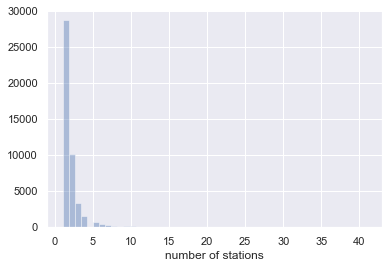

In [32]:
sns.distplot(station_rain.num, kde=False).set_xlabel("number of stations")

### the number of non-NaN stations per circle

In [23]:
station_rain.num_notna.describe()

count    45928.000000
mean         1.664540
std          1.708073
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         41.000000
Name: num_notna, dtype: float64

Text(0.5, 0, 'number of non-NaN stations')

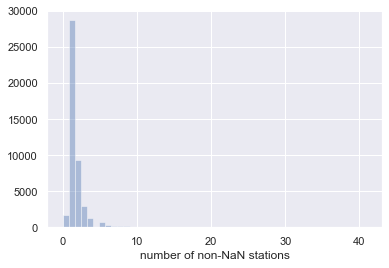

In [26]:
sns.distplot(station_rain.num_notna, kde=False).set_xlabel("number of non-NaN stations")

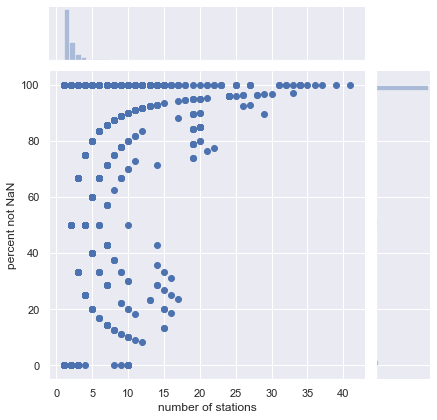

In [27]:
sns.jointplot(station_rain.num, station_rain.num_notna/station_rain.num * 100).set_axis_labels("number of stations", 'percent not NaN')

### percent of circles where all stations are missing data

In [25]:
(station_rain.num_notna == 0).sum() / station_rain.size * 100

0.301196075015967

### location, location, location

what percent of circles had the closest station as NaN?

In [30]:
station_rain.rain_closest.isna().sum() / len(station_rain) * 100

5.822156418742379

what percent had the average value differ from the closest value (ignoring NaNs)?

In [31]:
# use kleene logical indexing to skip over NAs
(station_rain.rain_closest_notna ^ (station_rain.p > AGREEMENT_THRESHOLD)).sum() / len(station_rain) * 100

3.165824769203972

In [58]:
station_obs.distance.describe()

count    82021.000000
mean      7681.614573
std       3988.117271
min          0.000000
25%       4424.482939
50%       7651.567462
75%      10984.505814
max      14998.957181
Name: distance, dtype: float64

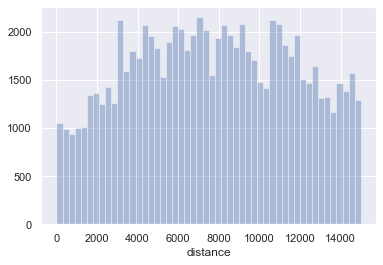

In [57]:
sns.distplot(station_obs.distance, kde=False)

### overall consensus of stations
we use `4 * p(1-p)` to estiamte the "disagreement" amongst stations: this value ranges from `0` (all in agrement) to `1` (evenly split)  
(here, `p` is the fraction of non-NaN stations that are `True` for rain)

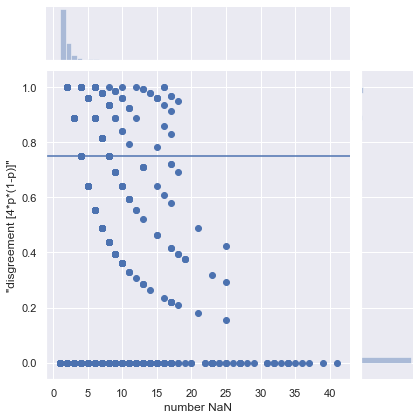

In [28]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(station_rain.num_notna, 4 * station_rain.p * (1 - station_rain.p))
p.set_axis_labels("number NaN", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

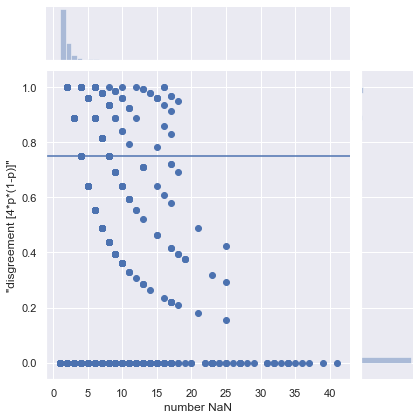

In [28]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(station_rain.num_notna, 4 * station_rain.p * (1 - station_rain.p))
p.set_axis_labels("number NaN", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

what percent do not meet our dissagreement threshold?

In [29]:
sum((station_rain.p >= (1-AGREEMENT_THRESHOLD)) & (station_rain.p <= AGREEMENT_THRESHOLD)) / len(station_rain) * 100

6.198832955931023

## the MISSING

In [69]:
station_rain_na_circle_idx = station_rain.c_rain.isna()

### percent of circles with missing rain observation

In [72]:
station_rain_na_circle_idx.sum() / len(station_rain) * 100

40.75074028914823

### percent of circles with both volunteer and all station data are missing

In [73]:
# joint
(station_rain_na_circle_idx & (station_rain.num_notna == 0)).sum() / len(station_rain) * 100

0.8796376937815712

In [74]:
# conditional 
(station_rain_na_circle_idx & (station_rain.num_notna == 0)).sum() / station_rain_na_circle_idx.sum() * 100

2.1585808933532804

In [25]:
# population
(station_rain.num_notna == 0).sum() / station_rain.size * 100

0.301196075015967

correlation between the two

In [101]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(station_rain_na_circle_idx, station_rain.num_notna == 0))
g, p

(191.46019126281416, 1.5261917003591202e-43)

if the circle is missing data, it is much more likely that all other stations will too, when compared to the general population

### percent of circles with both volunteer and the closest station data are missing

In [75]:
# joint
(station_rain_na_circle_idx & station_rain.rain_closest.isna()).sum()  / len(station_rain) * 100

1.2911513673576032

In [76]:
# conditional 
(station_rain_na_circle_idx & station_rain.rain_closest.isna()).sum() / station_rain_na_circle_idx.sum() * 100

3.168412053857662

In [102]:
# population
station_rain.rain_closest.isna().sum() / len(station_rain) * 100

5.822156418742379

In [103]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(station_rain_na_circle_idx, station_rain.rain_closest.isna()))
g, p

(404.8935163604215, 4.739075447736361e-90)

if the circle is missing data, it is much **less** likely that the closes station will have missing data, when compared to the general population

### number of stations for circles with missing data

In [122]:
actl = pd.crosstab(station_rain_na_circle_idx, station_rain.num_notna)
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(1711.4952301340618, 0.0)

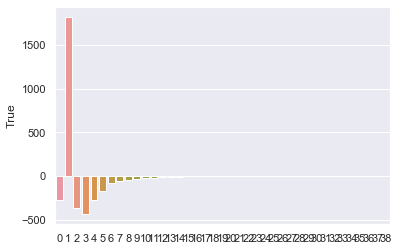

In [131]:
sns.barplot(np.arange(expctd.shape[1]), actl.loc[True] - expctd[1, :])

it looks like the circle being missing implies that there is only one non-na station?

### disagreement

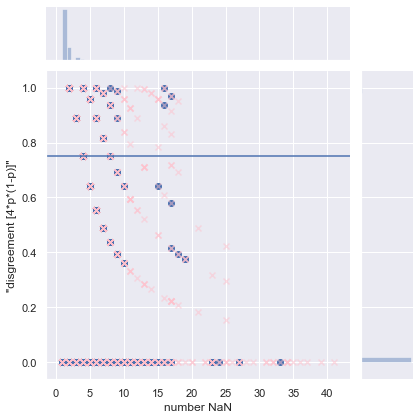

In [89]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(station_rain.loc[station_rain_na_circle_idx, 'num_notna'], 
                  4 * station_rain.loc[station_rain_na_circle_idx, 'p'] * (1 - station_rain.loc[station_rain_na_circle_idx, 'p']))
p.ax_joint.scatter(station_rain.num_notna, 4 * station_rain.p * (1 - station_rain.p), color='pink', marker='x', alpha=0.5)
p.set_axis_labels("number NaN", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

what percent do not meet our dissagreement threshold?

In [91]:
# joint
sum((station_rain.loc[station_rain_na_circle_idx, 'p'] >= (1-AGREEMENT_THRESHOLD)) & 
    (station_rain.loc[station_rain_na_circle_idx, 'p'] <= AGREEMENT_THRESHOLD)) / len(station_rain) * 100

1.7048423619578472

In [132]:
# conditional
sum((station_rain.loc[station_rain_na_circle_idx, 'p'] >= (1-AGREEMENT_THRESHOLD)) & 
    (station_rain.loc[station_rain_na_circle_idx, 'p'] <= AGREEMENT_THRESHOLD)) / station_rain_na_circle_idx.sum() * 100

4.183586236375294

In [133]:
# population
sum((station_rain.p >= (1-AGREEMENT_THRESHOLD)) & (station_rain.p <= AGREEMENT_THRESHOLD)) / len(station_rain) * 100

6.198832955931023

In [135]:
actl = pd.crosstab(station_rain_na_circle_idx, (station_rain.p >= (1-AGREEMENT_THRESHOLD)) & (station_rain.p <= AGREEMENT_THRESHOLD))
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(220.04736394079939, 8.831862781062105e-50)

In [138]:
actl - expctd

p,False,True
c_rain,,
False,-377.173576,377.173576
True,377.173576,-377.173576


missing your rain data imples the stations are more likely to consense

# the found

- what percentage of associated stations have missing data?
 - how many only had stations with missing data?
- what was the average number of associated stations that reported data
 - how many had at least 1 station reporting data?
- what was the average consensus ("probability" rain or snow)?
 - how many had stations that consensed (using the threshold)?
- what did the closest station say?
 - what did the closest non-NaN station say?